In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
matplotlib.rcParams["xtick.labelsize"] = 20
matplotlib.rcParams["ytick.labelsize"] = 20
matplotlib.rcParams["image.cmap"] = "inferno"
matplotlib.rcParams["axes.titlesize"] = 25
matplotlib.rcParams["axes.labelsize"] = 25
from matplotlib import pyplot as plt

import pulse
import modulated_tls
import single_photon_emission

In [2]:
class GaussianPulse(pulse.Pulse):
    def __init__(self, pulse_amp, t_mean, t_stddev):
        self._t_mean = t_mean
        self._t_stddev = t_stddev
        self._pulse_amp = pulse_amp

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        return self._pulse_amp * np.exp(
            -(t - self._t_mean)**2 / (self._t_stddev**2))
    
    
class RectangularPulse(pulse.Pulse):
    def __init__(self, pulse_amp, pulse_len):
        self._pulse_amp = pulse_amp
        self._pulse_len = pulse_len

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        if t < self._pulse_len:
            return self._pulse_amp
        else:
            return 0
        
def compute_fourier_transform(phi, times, freqs):
    df = freqs[1] - freqs[0]
    fft_matrix = np.exp(
        -1.0j * freqs[:, np.newaxis] @ times[np.newaxis, :])/ np.sqrt(2 * np.pi) * df
    return fft_matrix @ phi
    

In [8]:
# Reproducing transmission spectrum.
gamma = 98 * 1e-3
inp_freqs = np.linspace(-10, 10, 1000)
freq_2f = 1.500
amps = [2.910, 2.250]
phases = [0, 0]
harmonics = [1, 3]

delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)
tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta_2f)

pulse_width = 0.05 / gamma
pulse_area = np.pi
pulse_amp = pulse_area / (np.sqrt(np.pi) * pulse_width)
laser_pulse = GaussianPulse(pulse_amp, pulse_width, 3 * pulse_width)
times = np.linspace(0, 10 / gamma, 2000)
output_2f = single_photon_emission.single_photon_emission(
        tls_obj_2f, times, laser_pulse, 1)

output_2f_freq = compute_fourier_transform(output_2f, times, inp_freqs)

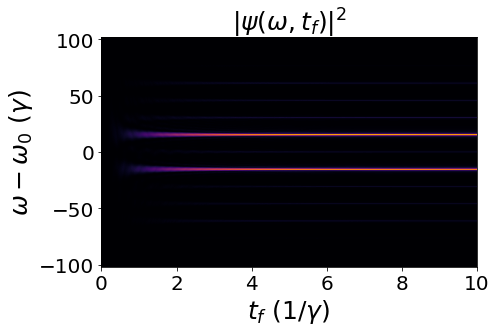

In [17]:
plt.figure(figsize=(7, 5))
plt.imshow(np.abs(output_2f_freq)**2, origin="lower", aspect=0.03,
           extent=[gamma * times[0], gamma * times[-1],
                   inp_freqs[0] / gamma, inp_freqs[-1] / gamma])
plt.xlabel("$t_f\ ( 1/\gamma)$")
plt.ylabel("$\omega - \omega_0\ (\gamma)$")
plt.title(r"$|\psi(\omega, t_f)|^2$")
plt.tight_layout()
plt.savefig("two_color_pulsing.pdf")

In [13]:
# Reproducing transmission spectrum.
gamma = 98 * 1e-3
inp_freqs = np.linspace(-10, 10, 1000)
freq_4f = 1.200
amps = [2.360, 2.110, 2.220, 2.020, 2.250]
phases = [np.pi / 6, -np.pi / 6, np.pi / 2, -5 * np.pi / 6, 5 * np.pi / 6]
harmonics = [1, 2, 3, 4, 5]
delta_4f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_4f)
tls_obj_4f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_4f)

pulse_width = 0.05 / gamma
pulse_area = np.pi
pulse_amp = pulse_area / (np.sqrt(np.pi) * pulse_width)
laser_pulse = GaussianPulse(10, pulse_width, 3 * pulse_width)
times = np.linspace(0, 10 / gamma, 2000)
output_4f = single_photon_emission.single_photon_emission(
        tls_obj_4f, times, laser_pulse, 1)

output_4f_freq = compute_fourier_transform(output_4f, times, inp_freqs)

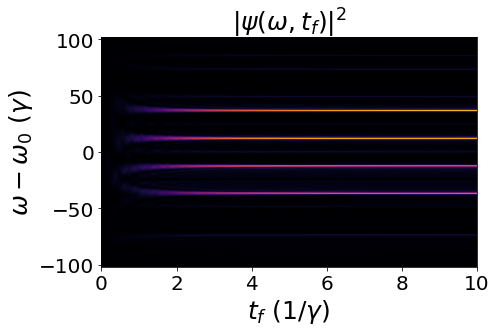

In [18]:
plt.figure(figsize=(7, 5))
plt.imshow(np.abs(output_4f_freq)**2, origin="lower", aspect=0.03,
           extent=[gamma * times[0], gamma * times[-1],
                   inp_freqs[0] / gamma, inp_freqs[-1] / gamma])
plt.xlabel("$t_f \ (1/\gamma)$")
plt.ylabel("$\omega - \omega_0 \ (\gamma)$")
plt.title(r"$|\psi(\omega, t_f)|^2$")
plt.tight_layout()
plt.savefig("four_color_pulsing.pdf")

## Pulse area vs P1

In [449]:
# Test a simple unmodulated TLS.
gamma = 0.181
pulse_width = 0.1 / gamma
pulse_areas = np.linspace(0, 4 * np.pi, 100)
em_probs = []

for pulse_area in pulse_areas:
    print("On pulse_area = {}".format(pulse_area))
    pulse_amp = pulse_area / (np.sqrt(np.pi) * pulse_width * np.sqrt(gamma))
    mw_freq = 0 * 2 * np.pi * 10
    mw_delta = 0 * 1.6 * 2 * np.pi * mw_freq
    freq_mean = 0 * mw_freq

    delta = pulse.SinusoidalPulse(freq_mean, mw_delta, 0, mw_freq)
    laser_pulse = GaussianPulse(pulse_amp, 10 * pulse_width, pulse_width)
    tls_obj = modulated_tls.ModulatedTwoLevelSystem(0, gamma, delta)
    times = np.linspace(0, 10 / gamma, 1000)
    state = single_photon_emission.compute_single_photon_state(
                    tls_obj, times, laser_pulse, 1)
    em_probs.append(np.sum(np.abs(state)**2) * (times[1] - times[0]))

On pulse_area = 0.0
On pulse_area = 0.12693303650867852
On pulse_area = 0.25386607301735703
On pulse_area = 0.3807991095260356
On pulse_area = 0.5077321460347141
On pulse_area = 0.6346651825433925
On pulse_area = 0.7615982190520711
On pulse_area = 0.8885312555607496
On pulse_area = 1.0154642920694281
On pulse_area = 1.1423973285781066
On pulse_area = 1.269330365086785
On pulse_area = 1.3962634015954636
On pulse_area = 1.5231964381041423
On pulse_area = 1.6501294746128208
On pulse_area = 1.7770625111214993
On pulse_area = 1.9039955476301778
On pulse_area = 2.0309285841388562
On pulse_area = 2.1578616206475347
On pulse_area = 2.284794657156213
On pulse_area = 2.4117276936648917
On pulse_area = 2.53866073017357
On pulse_area = 2.6655937666822487
On pulse_area = 2.792526803190927
On pulse_area = 2.9194598396996057
On pulse_area = 3.0463928762082846
On pulse_area = 3.173325912716963
On pulse_area = 3.3002589492256416
On pulse_area = 3.42719198573432
On pulse_area = 3.5541250222429985
On pul

Text(0.5, 0, 'Pulse Area')

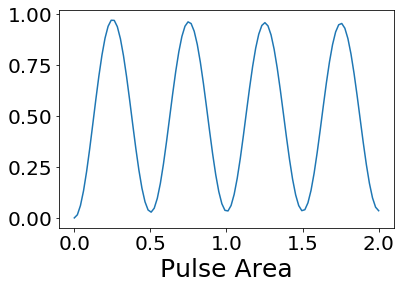

In [448]:
plt.plot(pulse_areas / (2 * np.pi), np.array(em_probs))
plt.xlabel("Pulse Area")

In [570]:
class AlexGaussianPulse(pulse.Pulse):
    def __init__(self, pulse_area, pulse_width):
        self._pulse_area = pulse_area
        self._pulse_width = pulse_width

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        t_cen = 3.5 * self._pulse_width
        pulse_amp = self._pulse_area / (np.sqrt(2 * np.pi) * self._pulse_width)
        return pulse_amp * np.exp(
            -(t - t_cen)**2 / (2 * self._pulse_width**2))
    
def discretize_gaussian_pulse(num_pulse, num_decay, gaussian_time, total_time):
    times = np.hstack((np.linspace(0, gaussian_time, num_pulse)[:-1],
                       np.linspace(gaussian_time, total_time, num_decay)))
    return times



pulse_widths = np.logspace(-3, 1, 59)
data = np.load("results/opt_params_All.npy")
init_phases = data[:, 0]
pulse_areas = data[:, 1]
gamma = 0.181
mw_freq = 20 * np.pi
mw_delta = 32 * np.pi
prob_mod = []
prob_static = []

for k, (pulse_width, init_phase, pulse_area) in enumerate(zip(
        pulse_widths, init_phases, pulse_areas)):
    print("Done {}".format(k))
    # Define laser pulse and discretization times.
    times = discretize_gaussian_pulse(500, 1000, 10 * pulse_width, 50 / gamma)
    
    # With modulation.
    laser_pulse = AlexGaussianPulse(0.5 * pulse_area / np.sqrt(gamma),
                                    pulse_width)
    delta = pulse.SinusoidalPulse(0, mw_delta, init_phase, mw_freq)
    tls_mod = modulated_tls.ModulatedTwoLevelSystem(mw_freq, gamma, delta)
    state = single_photon_emission.compute_single_photon_state(
                    tls_mod, times, laser_pulse, 1)
    prob_mod.append(np.trapz(np.abs(state)**2, times))
    
    # Without modulation.
    laser_pulse = AlexGaussianPulse(0.5 * np.pi / np.sqrt(gamma),
                                    pulse_width)
    delta = pulse.ConstantPulse(0)
    tls_mod = modulated_tls.ModulatedTwoLevelSystem(0, gamma, delta)
    state = single_photon_emission.compute_single_photon_state(
                    tls_mod, times, laser_pulse, 1)
    prob_static.append(np.trapz(np.abs(state)**2, times))
    


Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47
Done 48
Done 49
Done 50
Done 51
Done 52
Done 53
Done 54
Done 55
Done 56
Done 57
Done 58


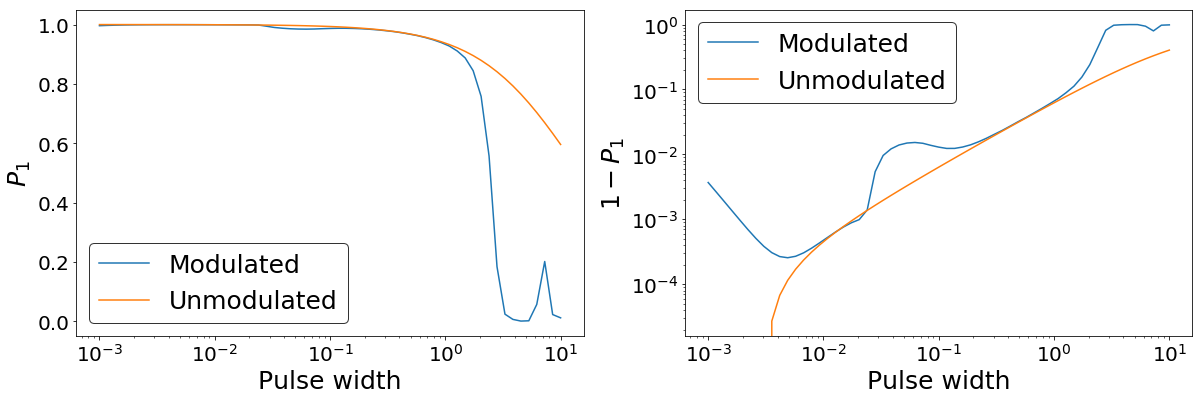

In [585]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(pulse_widths, prob_mod, label="Modulated")
plt.plot(pulse_widths, prob_static, label="Unmodulated")
plt.ylabel("$P_1$")
plt.xlabel("Pulse width")
plt.xscale("log")
plt.legend(fontsize=25, edgecolor="k")

plt.subplot(1, 2, 2)
plt.plot(pulse_widths, 1 - np.array(prob_mod), label="Modulated")
plt.plot(pulse_widths, 1 - np.array(prob_static), label="Unmodulated")
plt.ylabel("$1 - P_1$")
plt.xlabel("Pulse width")
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=25, edgecolor="k")